# Parameterized quantum circuits

In this section, we introduce parameterized quantum circuits, then describe their properties and implement some examples used in quantum machine learning. 

## Introduction

Parameterized quantum circuits, where the gates are defined through tunable parameters, are a fundamental building block of near-term quantum machine learning algorithms. In the literature, depending on the context, parameterized quantum circuits are also called parameterized trial states, variational forms or ansatze.

Here is an example of a simple parameterized circuit, with two parameterized gates, a single-qubit $z$-rotation gate, with a variable rotation $\theta$, followed by a two-qubit controlled $z$-rotation gate, with the same variable rotation $\theta$: 

![A quantum circuit with an RZ(theta) gate on qubit 0, followed by an CRZ(theta) controlled by qubit 0, targeting qubit 1](images/pqc/0.svg)

We can create the parameterized circuit above using the `QuantumCircuit` and `Parameter` classes. The `Parameter` class lets us add rotation gates, without having to specify what the angles are yet:

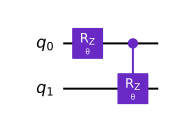

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw()

If we want the gates to have different parameters, we can use two `Parameters`, or we create a `ParameterVector`, which acts like a list of `Parameters`:

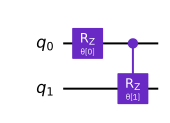

In [2]:
from qiskit.circuit import ParameterVector

theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw()

As all quantum gates used in a quantum circuit are [unitary](gloss:unitary), a parameterized circuit itself can be described as a unitary operation on $n$ qubits, $\mathbf{U_\theta}$, acting on some initial state $|\phi_0\rangle$, often set to $|0\rangle^{\otimes n}$. The resulting parameterized quantum state is $|\psi_\mathbf{\theta}\rangle = \mathbf{U_\theta} |\phi_0\rangle$ where $\mathbf{\theta}$ is a set of tunable parameters.

<!-- ::: q-block.exercise -->

### Quick quiz

<!-- ::: q-quiz(goal="qml-pqc-0") -->

<!-- ::: .question -->

Why are parameterized quantum circuits useful for near-term machine learning algorithms?

<!-- ::: -->

<!-- ::: .option(correct) -->

1. Parameterized quantum circuits offer a way to implement algorithms on near-term quantum devices.

<!-- ::: -->

<!-- ::: .option -->

2. Parameterized quantum circuits cannot be used to encode classical data.

<!-- ::: -->

<!-- ::: .option -->

3. Parameterized quantum circuits cannot express complex quantum states.

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

## Parameterized quantum circuit properties

How do we choose one parameterized circuit over the other? To use parameterized quantum circuits as a machine learning model, we need them to generalize well. This means that the circuit should be able to generate a significant subset of the states within the output [Hilbert space](gloss:hilbert-space). To avoid being easy to simulate on a classical computer, the circuit should also entangle qubits. 

In Reference 1, the authors propose the measures of *expressibility* and *entangling capability* to discriminate between different parameterized quantum circuits. We can think of the *expressibility* of a circuit as the extent to which it can generate states within the Hilbert space, while the *entangling capability* of a circuit describes its ability to generate entangled states.

### Expressibility

The *expressibility* of a parameterized quantum circuit is essentially the coverage of the Hilbert space by the circuit's hypothesis space. Highly expressive parameterized quantum circuits can represent many different unitaries. There are many ways to represent this expressibility, one such example can be found in Reference 1. Here the authors quantify it by computing the extent to which the states generated from the circuit deviate from the [uniform distribution](gloss:uniform-distribution). 

Let's compare the two following single-qubit circuits to get a sense of what it means for a circuit to be expressible or not, by sampling 2000 output states for each circuit and plotting them on a Bloch sphere. 

![Two single-qubit quantum circuits. Circuit 'A' has one H-gate followed by a RZ(theta) gate. Circuit 'B' has a H-gate, followed by an RZ(theta) gate, followed by an RX(phi) gate.](images/pqc/1.svg)

<!-- ::: q-block -->

### Exploring expressibility

    q-mini-composer(goal="pqc-minicomposer")
        .slide
            .circuit
                .autoMeasureGate
                .availableGates H RZ(theta)
                .initialCircuit
                    .qubit
                .goalCircuit
                    .qubit H RZ(theta)
            .instructions Recreate 'Circuit A'
            .lesson With this circuit, we can only access a small number of states.<br><img src="images/pqc/bloch_a.gif"><br>Above, we've plotted some output states for random values of θ.
            .info Nice one! Let's keep experimenting.
        .slide
            .circuit
                .autoMeasureGate
                .availableGates RX(phi)
                .initialCircuit
                    .qubit H RZ(theta)
                .goalCircuit
                    .qubit H RZ(theta) RX(phi)
            .instructions Recreate 'Circuit B'
            .lesson With this extra gate, we can now access many more states.<br><img src="images/pqc/bloch_b.gif"><br>Above, we've plotted some output states for random values of θ and Φ.
            .info Congrats!
<!-- ::: -->

For Circuit A, we see output states distributed about the equator of the Bloch sphere. With Circuit B's additional parameterized $z$-rotation gate, we can cover all the Bloch sphere with output states, but the coverage is not uniform; there are concentrations of points on the $+X$ and $-X$ poles of the Bloch sphere.

Expressibility is a way to quantify what we just observed for these single-qubit circuits. Circuit A would have a low expressibility score due to the limited set of states it can explore, whereas Circuit B would have a high expressibility score.  

<!-- ::: q-block.reminder -->

### Extra code

<details>
    <summary>Code to produce the Bloch sphere plots used in the exercise above</summary>

```python3
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()
```
</details>

<!-- ::: -->

### Entangling capability

Entanglement is a key resource in quantum computing. The [Meyer-Wallach measure](gloss:meyer-wallach-measure) is one of many metrics that measures how entangled a given state is. The Meyer-Wallach measure of an unentangled [product state](gloss:product-state) is 0, while the Meyer-Wallach measure of a highly entangled state, such as the Bell state, is 1. In Reference 1, the authors define the entangling capability of a parameterized quantum circuit as the average Meyer-Wallach measure for the states it can generate.

For example, consider the following multi-qubit parameterized circuits:

![Two four-qubit quantum circuits. Circuit 'A' has an RZ gate on each qubit, followed by an RX gate on each qubit. Circuit 'B' is the same as circuit A, but followed by three additional CNOT gates, acting on qubits 0&1, 2&3, and 1&2 in that order.](images/pqc/2.svg)

Circuit A has no entangling operations, that is, no two-qubit gates, so it has no entangling capability. Thus, this circuit would produce states that have Meyer-Wallach measures of 0, leading to an averaged value of 0. Circuit B has several two-qubit gates, so it can generate quantum states with some entanglement. Therefore, the average Meyer-Wallach measure would be greater than 0. 

Using these two parameterized quantum circuit descriptors, expressibility and entangling capability, we can identify circuits that have limited capabilities. We expect that limited circuits are poor candidates for quantum machine learning applications. Reference 2 investigates this for the [variational quantum classifier](gloss:variational-quantum-classifier); and for its datasets and parameterized circuits, it finds that there is a strong correlation between classification accuracy and expressibility, and a weak correlation between classification accuracy entangling capability.

### Hardware efficiency

In this era of near term quantum computing, where devices have limited [qubit connectivity](gloss:qubit-connectivity), [coherence times](gloss:coherence-time) and gate fidelities, the depth of the circuits we run directly affects the accuracy of our results, since there is limited error correction or mitigation.

Reference 3 introduces a class of hardware efficient parameterized circuits to accommodate device constraints. The common trait of these circuits is the use of a limited set of quantum gates as well as a particular qubit connection topology. The gate set usually consists of one two-qubit entangling gate and up to three single-qubit gates. The circuit is then constructed from blocks of single-qubit gates and entangling gates, which are applied to multiple or all qubits in parallel. One sequence of a single-qubit and an entangling block is called a layer, and the parameterized circuit generally has multiple layers.

Circuit B depicted in the 'Entangling Capability' section (also shown below) is an example of a single layer hardware efficient parameterized circuit.

![Circuit 'B' has a H-gate, followed by an RZ(theta) gate, followed by an RX(phi) gate.](images/pqc/circuit-b.svg)

<!-- ::: q-block.exercise -->

### Quick quiz

    q-carousel
        q-quiz(goal="qml-pqc-quizousel-0")
            .question.md _Expressibility_ describes...
            .option(x) The extent to which a parameterized circuit is able to generate states within the Hilbert space.
            .option How well the circuit will perform on near-term quantum hardware.
            .option The ability of a parameterized circuit to generate entangled states.

        q-quiz(goal="qml-pqc-quizousel-1")
            .question.md _Entangling capability_ describes...
            .option The extent to which a parameterized circuit is able to generate states within the Hilbert space.
            .option How well the circuit will perform on near-term quantum hardware.
            .option(x) The ability of a parameterized circuit to generate entangled states.

        q-quiz(goal="qml-pqc-quizousel-2")
            .question.md _Hardware efficiency_ describes...
            .option The extent to which a parameterized circuit is able to generate states within the Hilbert space.
            .option(x) How well the circuit will perform on near-term quantum hardware.
            .option The ability of a parameterized circuit to generate entangled states.

<!-- ::: -->

## Parameterized quantum circuits for machine learning

In quantum machine learning, parameterized quantum circuits tend to be used for two things:

- To encode data, where the parameters are determined by the data being encoded
- As a quantum model, where the parameters are determined by an optimization process.

Here we will give some examples of how to build parameterized quantum circuits used in the quantum machine learning literature using Qiskit. 

In Reference 4, the authors introduce the following parameterized circuit, used to encode data, which we will study in detail [later](./quantum-feature-maps-kernels):

$$
\mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right),
$$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$. This unitary was chosen because it is classically difficult to compute, but tractable on near term hardware. Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits: $S \in \{\binom{n}{k}\ \text{combinations},\ k = 1,... n \}$, and the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

Specifically, they use $k = 2, P_0 = Z, P_1 = ZZ$, which in Qiskit is the [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) circuit:

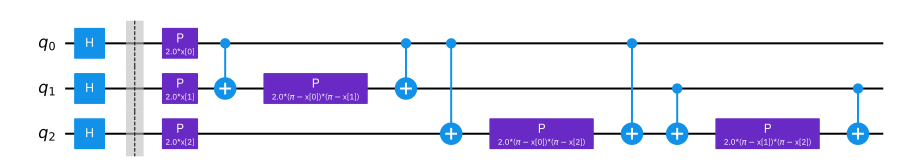

In [3]:
from qiskit.circuit.library import ZZFeatureMap

qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)

qc_zz.decompose().draw()

In Reference 4, the authors also use a hardware efficient circuit as a quantum model, consisting of alternating layers of single-qubit rotation gates, followed by two-qubit gates. In particular, they use $y$-and-$z$-rotation gates, and controlled-$z$ gates, which we can build using the [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) circuit:

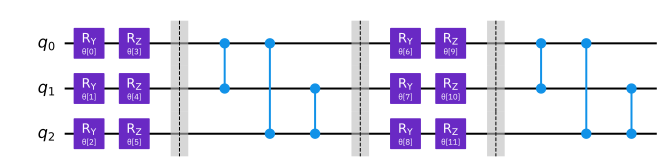

In [4]:
from qiskit.circuit.library import TwoLocal

qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw()

The `TwoLocal` circuit in Qiskit can create many parameterized circuits, such as circuit 13 in Reference 1:

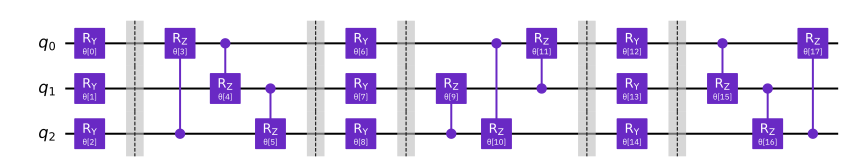

In [5]:
qc_13 = TwoLocal(3, rotation_blocks='ry',
                 entanglement_blocks='crz', entanglement='sca',
                 reps=3, skip_final_rotation_layer=True,
                 insert_barriers=True)

qc_13.decompose().draw()

Qiskit's [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) circuit can also create more general parameterized circuits with alternating rotation and entanglement layers. 

Here is a `NLocal` circuit, with a rotation block on 2 qubits and an entanglement block on 4 qubits using linear entanglement:

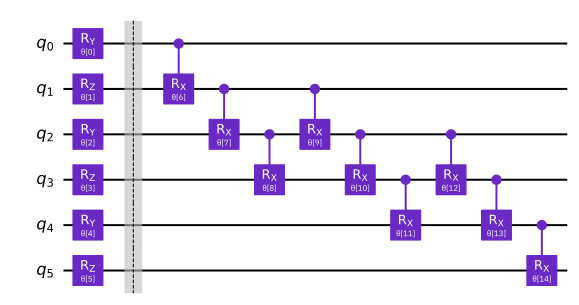

In [6]:
from qiskit.circuit.library import NLocal

# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw()

<!-- ::: q-block.exercise -->

### Try it

Try build your own parameterized quantum circuit using one of the [NLocal Circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) or [Data Encoding Circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits) in the Qiskit Circuit Library in the [IBM Quantum Lab](https://quantum-computing.ibm.com/lab).

<!-- ::: -->

## References

1. Sukin Sim, Peter D. Johnson and Alan Aspuru-Guzik, *Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms*,  	Advanced Quantum Technology 2 (2019) 1900070, [doi:10.1002/qute.201900070](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070), [arXiv:1905.10876](https://arxiv.org/abs/1905.10876).
2. Thomas Hubregtsen, Josef Pichlmeier, and Koen Bertels, *Evaluation of Parameterized Quantum Circuits: On the Design, and the Relation between Classification Accuracy, Expressibility and Entangling Capability* 2020, [arXiv:2003.09887](https://arxiv.org/abs/2003.09887).
3. Abhinav Kandala, Antonio Mezzacapo, Kristan Temme, Maika Takita, Markus Brink, Jerry M. Chow and Jay M. Gambetta, *Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets*, Nature 549, 242–246 (2017), [doi.org/10.1038/nature23879](https://doi.org/10.1038/nature23879), [arXiv:1704.05018](https://arxiv.org/abs/1704.05018)
4. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326).

In [7]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
